In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
from astropy import units as u
plt.rcParams['axes.grid'] = False

from astropy.io.votable import parse


pd.options.mode.chained_assignment = None

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

## Enfoque en el primer cascaron (0,100) pc. Se toman todas las estrellas en gedr3dist.main con r_med_geo<100
## Stars with dr2_radial_velocity_error, pmra_error, pmdec_error and parallax_error greater than 10% are left out.

SELECT gaia.source_id, ra, dec,l,b, parallax,
parallax_over_error, pmra, pmra_error, pmdec,
pmdec_error, dr2_radial_velocity,
dr2_radial_velocity_error, r_med_geo,
r_lo_geo, r_hi_geo
FROM gaiaedr3.gaia_source AS gaia
JOIN external.gaiaedr3_distance AS within
ON gaia.source_id = within.source_id
WHERE within.r_med_geo<100
AND dr2_radial_velocity_error/dr2_radial_velocity<0.1
AND pmra_error/pmra<0.1
AND pmdec_error/pmdec<0.1
AND parallax_over_error>10

In [3]:
results= votable_to_pandas('within1000-result.vot.gz') #toma alrededor de 3 minutos en leer
r=1000 #RADIO de busqueda, pc.
results.dropna(inplace=True)
len(results)

2500666

## Sky grid

### Building spheric cubes

In [4]:
class Cube:
  def __init__(self, id, li, lf,bi,bf, ri,rf):
    self.id = id
    self.li = li
    self.lf = lf
    self.bi = bi
    self.bf = bf
    self.ri = ri
    self.rf = rf
    self.stars = pd.DataFrame()
    self.avgpmra= pd.NA
    self.avgpmdec= pd.NA
    self.pmra_std= pd.NA
    self.pmdec_std= pd.NA
    self.pmra_outliers= pd.DataFrame()
    self.pmdec_outliers= pd.DataFrame()
    self.pmra_rms= pd.NA
    self.pmdec_rms= pd.NA
    self.pmra_outlier_ratio= pd.NA
    self.pmdec_outlier_ratio= pd.NA
    self.both_outlier_ratio= pd.NA

In [5]:
#Particiones de los intervalos, longitud, latitud, distancia.
#Este algoritmo asume particiones regulares para todos los intervalos.

nl= 20
nb= 20
nr= 20

ls= np.linspace(0,360,nl) 
bs= np.linspace(-90,90,nb)

length_l= 360/nl

def rf(thetai, thetaf, ri):
  k=np.radians(length_l)*(np.sin(np.radians(thetaf)-np.sin(np.radians(thetai))))
  V= r**3/3 * k
  return (3*(V/(nr-1))/k + ri**3)**(1/3)

cubes=[0]*((nl-1)*(nb-1)*(nr-1))

cubes_frontera=[0]*nr
cubes_frontera[0]=Cube(0, ls[0], ls[1], bs[0], bs[1], 0,0)


counter=0
for i in range(nr-1):
  for j in range(nb-1):
    for k in range(nl-1):
      cubes[counter]=Cube(counter, ls[k] , ls[k+1], bs[j], bs[j+1], cubes_frontera[i].rf, rf(bs[j], bs[j+1],cubes_frontera[i].rf))
      counter+=1
  cubes_frontera[i+1]= cubes[counter-1]

In [6]:
len(cubes)

6859

### Now, we need to add each star to its cube.

The filters by distance only work if the angular lengths of the spheric cube are small enough. If this condition isn't met, errors could appear. This is due to compare distances along axis (the cube's and the star's) that are not totally parallel.

In [7]:
for cube in cubes:  
  cube.stars = results.query(f'l<{cube.lf} & l>{cube.li} & b<{cube.bf} & b>{cube.bi} & r_med_geo<{cube.rf} & r_med_geo>{cube.ri}')
  cube.stars['cube_id']= cube.id
  if len(cube.stars)!=0:
    cube.avgpmra = cube.stars.pmra.mean()
    cube.avgpmdec = cube.stars.pmdec.mean()
    cube.pmra_std= np.std(cube.stars.pmra)
    cube.pmdec_std= np.std(cube.stars.pmdec)

## Finding outliers

Any star with any of its proper motion features (pmra, pmdec) beyond $\mu \pm 3σ$ of its cube is considered as an outlier

In [12]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.stars['pmra_deviation'] = cube.avgpmra - cube.stars.pmra
    cube.stars['pmdec_deviation'] = cube.avgpmdec - cube.stars.pmdec

In [13]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outliers= cube.stars.query(f'pmra_deviation<{-3*cube.pmra_std} | pmra_deviation>{3*cube.pmra_std}')
    cube.pmdec_outliers= cube.stars.query(f'pmdec_deviation<{-3*cube.pmdec_std} | pmdec_deviation>{3*cube.pmdec_std}')

### Calculating outliers ratio and rms

In [14]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outlier_ratio= len(cube.pmra_outliers)/len(cube.stars)
    if len(cube.pmra_outliers)!=0:
      cube.pmra_rms= np.sqrt(np.sum((cube.avgpmra - cube.pmra_outliers.pmra)**2)/len(cube.pmra_outliers))
    

    cube.pmdec_outlier_ratio= len(cube.pmdec_outliers)/len(cube.stars) 
    if len(cube.pmdec_outliers)!=0:
      cube.pmdec_rms= np.sqrt(np.sum((cube.avgpmdec - cube.pmdec_outliers.pmdec)**2)/len(cube.pmdec_outliers))
    
    cube.both_outlier_ratio= len(set(cube.pmra_outliers.source_id) & set(cube.pmdec_outliers.source_id))/len(cube.stars)


In [15]:
df_cubes= pd.DataFrame({
    'id': [ cube.id for cube in cubes],
    'r_med': [(np.round(cube.ri,3) + np.round(cube.rf,3))/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra': [ cube.avgpmra for cube in cubes],
    'pmdec': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes],
    'pmra_rms': [cube.pmra_rms for cube in cubes],
    'pmdec_rms': [cube.pmdec_rms for cube in cubes],
    'pmra_outlier_ratio': [cube.pmra_outlier_ratio for cube in cubes],
    'pmdec_outlier_ratio': [cube.pmdec_outlier_ratio for cube in cubes],
    'both_outlier_ratio': [cube.both_outlier_ratio for cube in cubes]
})
df_cubes.dropna(inplace=True)

### ¿Cómo cambian los ratios de outliers a medida que nos alejamos del sol?

SIEMPRE TENER EN CUENTA EL DTYPE DE LAS COLUMNAS

In [16]:
df_cubes.astype(float).groupby('r_med').mean()

,id,l_med,b_med,pmra,pmdec,std_pmra,std_pmdec,pmra_rms,pmdec_rms,pmra_outlier_ratio,pmdec_outlier_ratio,both_outlier_ratio
r_med,,,,,,,,,,,,
187.3780,180.000000,180.000000,-7.085745e-15,-1.014023,-14.581265,49.390035,44.140365,336.934734,296.802795,0.015025,0.015249,0.004623
423.4595,537.306962,181.798801,-1.888741e+00,-0.674347,-6.552719,16.302118,15.031760,68.532145,68.514936,0.008595,0.009245,0.001850
506.3275,900.219931,183.385784,-9.766685e-01,-0.973483,-5.400881,13.550847,12.563123,56.574037,54.759987,0.008810,0.009745,0.001801
567.6900,1259.454545,179.700437,-1.759933e+00,-0.913232,-4.741146,11.605351,11.041731,45.995375,49.790187,0.009594,0.009497,0.002177
617.8560,1619.705628,179.671907,-2.132604e+00,-0.884944,-4.279235,10.391197,9.929417,41.908813,42.224452,0.009728,0.009854,0.001938
660.9005,1981.268519,180.964912,-1.885965e+00,-0.901033,-3.897949,9.542418,9.591064,37.843548,43.153050,0.009283,0.009998,0.002516
698.9300,2344.102151,184.685908,-1.069610e+00,-1.165835,-3.649707,8.853481,8.901001,37.292530,38.601246,0.010022,0.010208,0.002611
733.1975,2704.241758,173.233083,-1.197224e+00,-1.068582,-3.519594,8.526059,8.671991,35.779013,36.811198,0.011033,0.010993,0.002762
764.5180,3065.395210,182.382603,-1.361488e+00,-1.322172,-3.479432,8.281341,8.275831,33.415284,34.739303,0.011739,0.011633,0.003220


In [17]:
ratio_means= df_cubes.astype(float).groupby('r_med').mean()
ratio_l_means= df_cubes.astype(float).groupby('l_med').mean()
ratio_b_means= df_cubes.astype(float).groupby('b_med').mean()

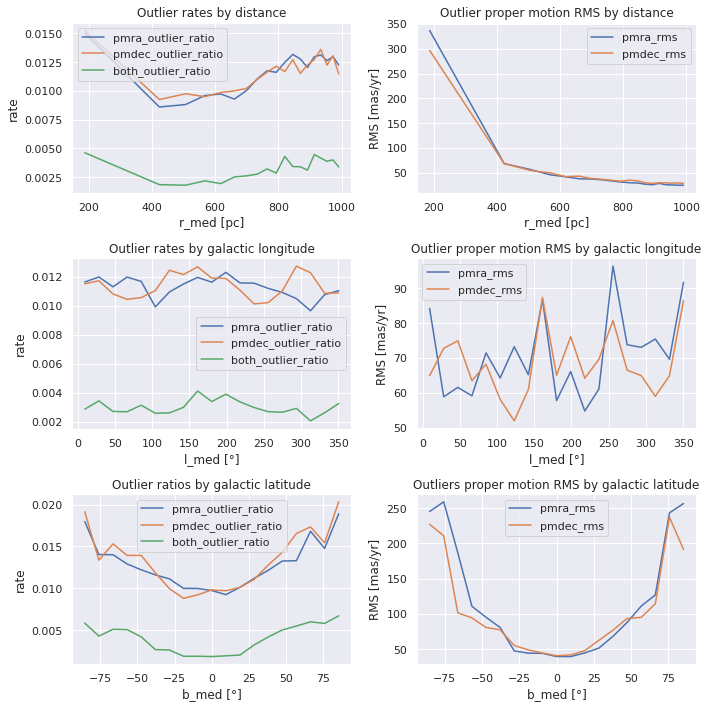

In [18]:
plt.figure(figsize=(10,10))
ax= plt.subplot(3,2,1)
ax.set_title('Outlier rates by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax)
ax.set_xlabel('r_med [pc]')
ax.set_ylabel('rate')
plt.grid()


ax1=plt.subplot(3,2,2)
ax1.set_title('Outlier proper motion RMS by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_rms', label='pmra_rms',  ax=ax1)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_rms', label='pmdec_rms',  ax=ax1)
ax1.set_xlabel('r_med [pc]')
ax1.set_ylabel('RMS [mas/yr]')
plt.grid()


ax2=plt.subplot(3,2,3)
ax2.set_title('Outlier rates by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax2)
ax2.set_xlabel('l_med [°]')
ax2.set_ylabel('rate')
plt.grid()

ax3=plt.subplot(3,2,4)
ax3.set_title('Outlier proper motion RMS by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_rms', label='pmra_rms', ax=ax3)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_rms', label='pmdec_rms', ax=ax3)
ax3.set_xlabel('l_med [°]')
ax3.set_ylabel('RMS [mas/yr]')
plt.grid()


ax4=plt.subplot(3,2,5)
ax4.set_title('Outlier ratios by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax4)
ax4.set_xlabel('b_med [°]')
ax4.set_ylabel('rate')
plt.grid()

ax6=plt.subplot(3,2,6)
ax6.set_title('Outliers proper motion RMS by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_rms', label='pmra_rms', ax=ax6)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_rms', label='pmdec_rms', ax=ax6)
ax6.set_xlabel('b_med [°]')
ax6.set_ylabel('RMS [mas/yr]')


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Densidad de estrellas

### pmra and pmdec outliers

In [19]:
pmra_outliers= pd.concat([ cube.pmra_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)
pmdec_outliers= pd.concat([ cube.pmdec_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)

### both pmra and pmdec outliers

In [20]:
common= pd.DataFrame(list(set(pmra_outliers.source_id) & set(pmdec_outliers.source_id)), columns=['source_id'])
both_outliers= pd.merge(common,results, on=['source_id'])

## Exporting files as csv

In [26]:
cubos= pd.DataFrame({
    'r_med': [(cube.ri + cube.rf)/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra_med': [ cube.avgpmra for cube in cubes],
    'pmdec_med': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes]
})

In [27]:
#cubos
cubos.to_csv('cubos.csv')

#En pmra, pmdec
pmra_outliers.to_csv('pmra_outliers.csv')
pmdec_outliers.to_csv('pmdec_outliers.csv')

#En ambos
both_outliers.to_csv('both_outliers.csv')

## Heatmaps

In [28]:
maps = [df_cubes.query(f'r_med=={dist}') for dist in df_cubes.r_med.unique()]

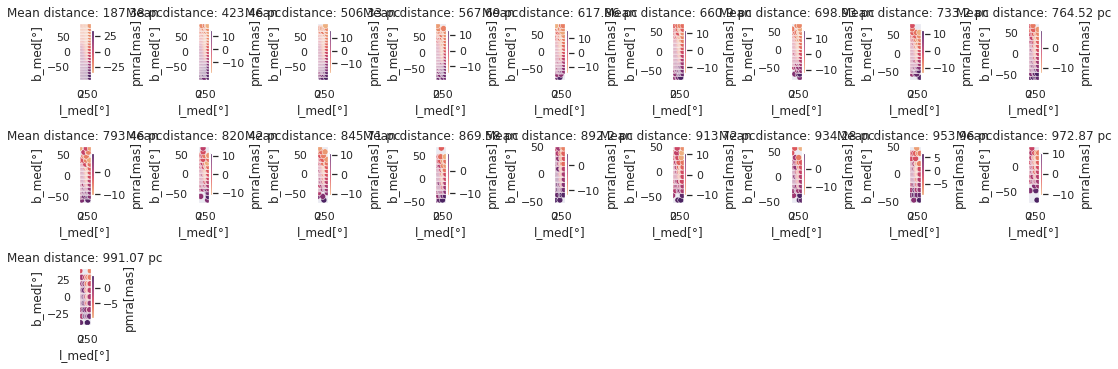

In [29]:
plt.figure(figsize=(15,15))

for j,map in enumerate(maps):
  ax= plt.subplot(int(len(maps)/2),int(len(maps)/2), j+1)
  ax.set_title(f'Mean distance: {np.round(df_cubes.r_med.unique()[j],2)} pc')
  
  norm = plt.Normalize(map['pmra'].min(), map['pmra'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= map, x= 'l_med', y='b_med', hue='pmra', palette='flare')

  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmra[mas]')
  ax.set_xlabel('l_med[°]')
  ax.set_ylabel('b_med[°]')

plt.tight_layout()
plt.show()

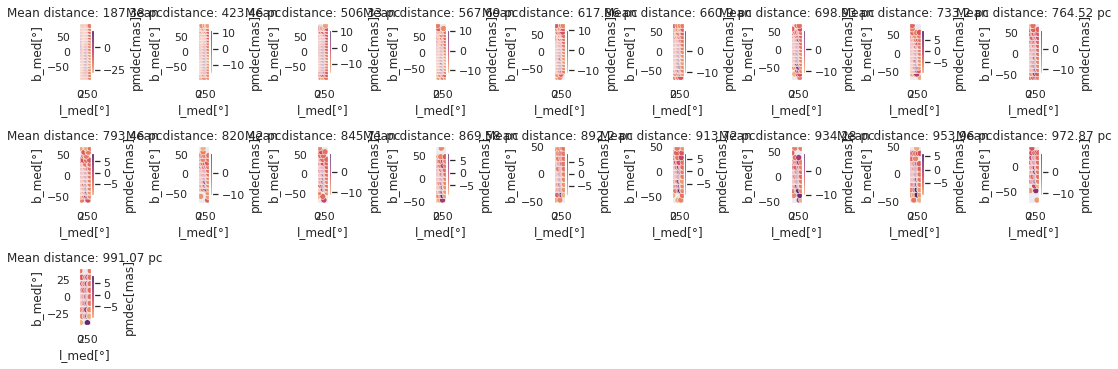

In [30]:
plt.figure(figsize=(15,15))

for j,map in enumerate(maps):
  ax= plt.subplot(int(len(maps)/2),int(len(maps)/2), j+1)
  ax.set_title(f'Mean distance: {np.round(df_cubes.r_med.unique()[j],2)} pc')
  
  norm = plt.Normalize(map['pmdec'].min(), map['pmdec'].max())
  cb = plt.cm.ScalarMappable(cmap="flare", norm=norm)

  sns.scatterplot(data= map, x= 'l_med', y='b_med', hue='pmdec', palette='flare')

  ax.legend().set_visible(False)
  ax.figure.colorbar(cb, label='pmdec[mas]')
  ax.set_xlabel('l_med[°]')
  ax.set_ylabel('b_med[°]')

plt.tight_layout()
plt.show()